# Document Overview

**Purpose:**
Training and Evaluating the Model

**Input file:** 
1. Model input data: './np_save/sample_sets.npy'
2. POI_cat_distrib : './np_save/poi_cat_distrib.npy'
3. POI distance matrix: './np_save/dist_mat.npy'
4. Maximum distance and sequence length: './np_save/max_dist.npy', './np_save/max_seq_len.npy'

**Output file:** 
tbd

**Creation Date:** 9th Nov 2019

In [1]:
# dependencies

import tensorflow as tf
import numpy as np
import random

In [2]:
# import custom library

import Helper_Functions as Helper

In [3]:
# import input data

# dir = './test_np_save/'
dir = './np_save/'

samples = Helper.load_dict(dir + 'sample_sets.pkl')
POI_cat_distrib = Helper.load_dict(dir + 'poi_cat_distrib.pkl')
dist_mat = np.load(dir + 'dist_mat.npy', allow_pickle=True)

POI_reIndex_mapping = np.load(dir + 'POI_reIndex_mapping.npy', allow_pickle=True)
user_reIndex_mapping = np.load(dir + 'user_reIndex_mapping.npy', allow_pickle=True)
cat_reIndex_mapping = np.load(dir + 'cat_reIndex_mapping.npy', allow_pickle=True)

max_dist = np.load(dir + 'max_dist.npy', allow_pickle=True)
max_seq_len = np.load(dir + 'max_seq_len.npy', allow_pickle=True)
neg_num = np.load(dir + 'neg_sample_num.npy', allow_pickle=True)

In [4]:
samples

{0: [([715, 1010, 1214],
   [0, 1, 1],
   [10, 11, 11],
   [1, 1, 0],
   [5, 19, 13],
   [[1241, 127, 0],
    [1221, -1, 1],
    [1240, 117, 0],
    [1218, -1, 1],
    [1217, 130, 0]]),
  ([490, 565, 614],
   [0, 2, 7],
   [11, 19, 19],
   [0, 0, 1],
   [25, 5, 11],
   [[620, -1, 1], [831, -1, 1], [830, -1, 1], [829, -1, 1], [828, -1, 1]]),
  ([490, 565, 614, 974],
   [0, 2, 7, 2],
   [11, 19, 19, 19],
   [0, 0, 1, 0],
   [25, 5, 11, 26],
   [[1241, 127, 0],
    [1073, -1, 1],
    [1074, -1, 1],
    [1075, -1, 1],
    [1076, -1, 1]])],
 1: [([715, 489, 607],
   [0, 6, 6],
   [9, 13, 17],
   [1, 0, 1],
   [5, 25, 15],
   [[620, -1, 1], [831, -1, 1], [830, -1, 1], [829, -1, 1], [828, -1, 1]]),
  ([164, 929],
   [0, 2],
   [9, 13],
   [1, 1],
   [33, 34],
   [[1241, 127, 0],
    [1028, 19, 0],
    [1029, 19, 0],
    [1030, 19, 0],
    [1031, 19, 0]])],
 2: [([599, 1100],
   [0, 1],
   [15, 15],
   [1, 0],
   [4, 22],
   [[1241, 127, 0],
    [1162, -1, 1],
    [1161, -1, 1],
    [1160, -1,

# 1. Set Hyper Parameter

In [5]:
# set hyper parameter

# sampling parameter
train_portion = 0.9
np_rand_seed = 2019
np.random.seed(np_rand_seed)
random.seed(2019)

# model parameter
RNN_stack_layers = 1
hidden_size = 50

# training parameter
batch_size = 1
lr = 1e-5
iter_num = 10000
break_threshold = 0.0001

# overfit control
keep_prob = 0.7
reg_beta = 0.0025

# embedding size
poi_size = len(POI_reIndex_mapping)
dist_size = 100#max_dist + 1
time_size = 24
user_size = len(user_reIndex_mapping)
cat_size = len(cat_reIndex_mapping)

# Prepare Train Test Set

In [6]:
# train test split after shuffling

all_samples = []

# user_samples = samples[0]

# random.shuffle(user_samples)

# all_samples.append(user_samples)

for key in samples.keys():
    
    user_samples = samples[key]
    
    random.shuffle(user_samples)
    
    all_samples.append(user_samples)

all_samples

[[([490, 565, 614],
   [0, 2, 7],
   [11, 19, 19],
   [0, 0, 1],
   [25, 5, 11],
   [[620, -1, 1], [831, -1, 1], [830, -1, 1], [829, -1, 1], [828, -1, 1]]),
  ([490, 565, 614, 974],
   [0, 2, 7, 2],
   [11, 19, 19, 19],
   [0, 0, 1, 0],
   [25, 5, 11, 26],
   [[1241, 127, 0],
    [1073, -1, 1],
    [1074, -1, 1],
    [1075, -1, 1],
    [1076, -1, 1]]),
  ([715, 1010, 1214],
   [0, 1, 1],
   [10, 11, 11],
   [1, 1, 0],
   [5, 19, 13],
   [[1241, 127, 0],
    [1221, -1, 1],
    [1240, 117, 0],
    [1218, -1, 1],
    [1217, 130, 0]])],
 [([715, 489, 607],
   [0, 6, 6],
   [9, 13, 17],
   [1, 0, 1],
   [5, 25, 15],
   [[620, -1, 1], [831, -1, 1], [830, -1, 1], [829, -1, 1], [828, -1, 1]]),
  ([164, 929],
   [0, 2],
   [9, 13],
   [1, 1],
   [33, 34],
   [[1241, 127, 0],
    [1028, 19, 0],
    [1029, 19, 0],
    [1030, 19, 0],
    [1031, 19, 0]])],
 [([565, 1180, 110],
   [0, 8, 1],
   [9, 12, 15],
   [0, 1, 0],
   [5, 13, 27],
   [[620, -1, 1], [830, -1, 1], [829, -1, 1], [828, -1, 1], [82

In [7]:
# split train test samples

all_training_samples, all_testing_samples = [], []

for user_samples in all_samples:

    N = len(user_samples)
    train_test_boundary = int(train_portion*N)

    all_training_samples.append(user_samples[:train_test_boundary])
    all_testing_samples.append(user_samples[train_test_boundary:])

In [8]:
all_training_samples

[[([490, 565, 614],
   [0, 2, 7],
   [11, 19, 19],
   [0, 0, 1],
   [25, 5, 11],
   [[620, -1, 1], [831, -1, 1], [830, -1, 1], [829, -1, 1], [828, -1, 1]]),
  ([490, 565, 614, 974],
   [0, 2, 7, 2],
   [11, 19, 19, 19],
   [0, 0, 1, 0],
   [25, 5, 11, 26],
   [[1241, 127, 0],
    [1073, -1, 1],
    [1074, -1, 1],
    [1075, -1, 1],
    [1076, -1, 1]])],
 [([715, 489, 607],
   [0, 6, 6],
   [9, 13, 17],
   [1, 0, 1],
   [5, 25, 15],
   [[620, -1, 1], [831, -1, 1], [830, -1, 1], [829, -1, 1], [828, -1, 1]])],
 [([565, 1180, 110],
   [0, 8, 1],
   [9, 12, 15],
   [0, 1, 0],
   [5, 13, 27],
   [[620, -1, 1], [830, -1, 1], [829, -1, 1], [828, -1, 1], [827, -1, 1]]),
  ([565, 1180, 110, 107],
   [0, 8, 1, 1],
   [9, 12, 15, 17],
   [0, 1, 0, 0],
   [5, 13, 27, 27],
   [[620, -1, 1], [830, -1, 1], [829, -1, 1], [828, -1, 1], [827, -1, 1]])],
 [([1177, 1042],
   [0, 2],
   [13, 20],
   [1, 0],
   [5, 73],
   [[1241, 127, 0],
    [1122, 50, 0],
    [1121, 50, 0],
    [1120, 181, 0],
    [1119, 

In [9]:
all_testing_samples

[[([715, 1010, 1214],
   [0, 1, 1],
   [10, 11, 11],
   [1, 1, 0],
   [5, 19, 13],
   [[1241, 127, 0],
    [1221, -1, 1],
    [1240, 117, 0],
    [1218, -1, 1],
    [1217, 130, 0]])],
 [([164, 929],
   [0, 2],
   [9, 13],
   [1, 1],
   [33, 34],
   [[1241, 127, 0],
    [1028, 19, 0],
    [1029, 19, 0],
    [1030, 19, 0],
    [1031, 19, 0]])],
 [([599, 1100],
   [0, 1],
   [15, 15],
   [1, 0],
   [4, 22],
   [[1241, 127, 0],
    [1162, -1, 1],
    [1161, -1, 1],
    [1160, -1, 1],
    [1159, -1, 1]])],
 [([107, 1226],
   [0, 1],
   [15, 16],
   [0, 1],
   [27, 27],
   [[1241, 127, 0],
    [1239, 117, 0],
    [1238, 117, 0],
    [1237, -1, 1],
    [1236, 98, 0]])],
 [([122, 842, 933],
   [0, 1, 1],
   [15, 16, 16],
   [0, 1, 1],
   [39, 70, 6],
   [[1241, 127, 0],
    [1034, 58, 0],
    [1035, 58, 0],
    [1036, 58, 0],
    [1037, 58, 0]])],
 [([825, 800, 0, 929],
   [0, 1, 1, 1],
   [16, 16, 16, 16],
   [1, 1, 1, 1],
   [38, 39, 16, 89],
   [[1241, 127, 0],
    [1096, 43, 0],
    [1097,

In [10]:
def generate_cat_vec_seq(poi_seq, type_seq, cat_seq, POI_cat_distrib):
    
    cat_vec_seq = np.zeros([len(cat_seq), len(cat_reIndex_mapping)])
    
    for visit in range(len(type_seq)):
        
        if type_seq[visit] == 0:
            cat_vec_seq[visit][cat_seq[visit]] = 1
            
        else: # collective
            total_store = sum(POI_cat_distrib[poi_seq[visit]].values())
            
            for cat in POI_cat_distrib[poi_seq[visit]].keys():
                cat_vec_seq[visit][cat] = POI_cat_distrib[poi_seq[visit]][cat] / total_store
                
    return cat_vec_seq # [seq_len, cat_size]

In [11]:
# generate training sample

def data_feeder(sample):
    
    feed_dict = {}
    
    poi_x = sample[0][:-1]
    poi_y = sample[0][-1]
    dist_x = sample[1][:-1]
    dist_y = sample[1][-1]
    time_x = sample[2][:-1]
    time_y = sample[2][-1]
    type_x = sample[3][:-1]
    type_y = sample[3][-1]
    cat_x = generate_cat_vec_seq(poi_x, type_x, sample[4][:-1], POI_cat_distrib)
    cat_y = generate_cat_vec_seq([poi_y], [type_y], [sample[4][-1]], POI_cat_distrib)
    
    poi_neg = []
    type_neg = []
    cat_neg = []
    dist_neg = []
    time_neg = []
    for neg_sample in sample[5]:
        poi_neg.append(neg_sample[0])
        type_neg.append(neg_sample[2])
        cat_neg.append(generate_cat_vec_seq([neg_sample[0]], [neg_sample[2]], [neg_sample[1]], POI_cat_distrib)[0])
        dist_neg.append(dist_mat[neg_sample[0]][poi_y])
        time_neg.append(time_y)
    
    feed_dict['x_poi'] = [poi_x]
    feed_dict['x_dist'] = [dist_x]
    feed_dict['x_time'] = [time_x]
    feed_dict['x_type'] = [type_x]
    feed_dict['x_cat'] = [cat_x]
    
    feed_dict['y_poi'] = [[poi_y]]
    feed_dict['y_dist'] = [[dist_y]]
    feed_dict['y_time'] = [[time_y]]
    feed_dict['y_type'] = [[type_y]]
    feed_dict['y_cat'] = [cat_y]
    feed_dict['true_y_cat'] = [[sample[4][-1]]] # for evaluation
    
    feed_dict['neg_poi'] = [poi_neg]
    feed_dict['neg_dist'] = [dist_neg]
    feed_dict['neg_time'] = [time_neg]
    feed_dict['neg_type'] = [type_neg]
    feed_dict['neg_cat'] = [cat_neg]
    
    return feed_dict

# 2. Construct Model

## Placeholders

In [12]:
x_poi = tf.placeholder(tf.int32, shape = [None, None]) # [batch, seq_len]
x_dist = tf.placeholder(tf.int32, shape = [None, None]) # [batch, seq_len]
x_time = tf.placeholder(tf.int32, shape = [None, None]) # [batch, seq_len]
x_type = tf.placeholder(tf.int32, shape = [None, None]) # [batch, seq_len]
x_cat = tf.placeholder(tf.float32, shape = [None, None, cat_size]) # [batch, seq_len, cat_size]

y_poi = tf.placeholder(tf.int32, shape = [None, 1]) # [batch, seq_len]
y_dist = tf.placeholder(tf.int32, shape = [None, 1]) # [batch, seq_len]
y_time = tf.placeholder(tf.int32, shape = [None, 1]) # [batch, seq_len]
y_type = tf.placeholder(tf.int32, shape = [None, 1]) # [batch, seq_len]
y_cat = tf.placeholder(tf.float32, shape = [None, 1, cat_size]) # [batch, seq_len, cat_size]
true_y_cat = tf.placeholder(tf.int32, shape = [None, 1]) # [batch, seq_len]
saved_user_rep = tf.placeholder(tf.float32, shape = [None, 1, hidden_size]) # dynamic user represenation for testing

neg_poi = tf.placeholder(tf.int32, [None, neg_num]) # [batch, seq_len]
neg_dist = tf.placeholder(tf.int32, [None, neg_num]) # [batch, seq_len]
neg_time = tf.placeholder(tf.int32, [None, neg_num]) # [batch, seq_len]
neg_type = tf.placeholder(tf.int32, [None, neg_num]) # [batch, seq_len]
neg_cat = tf.placeholder(tf.float32, [None, neg_num, cat_size]) # [batch, seq_len, cat_size]

## Variables

In [13]:
# embeddings
user_emb = tf.Variable(tf.random_uniform([user_size, hidden_size], -1.0, 1.0))
poi_emb = tf.Variable(tf.random_uniform([poi_size, hidden_size], -1.0, 1.0))
cat_emb = tf.Variable(tf.random_uniform([cat_size, hidden_size], -1.0, 1.0))
type_emb = tf.Variable(tf.random_uniform([2, hidden_size], -1.0, 1.0))
time_emb = tf.Variable(tf.random_uniform([time_size, hidden_size], -1.0, 1.0))
dist_emb = tf.Variable(tf.random_uniform([dist_size, hidden_size], -1.0, 1.0))

# weights
init_weight = tf.truncated_normal([hidden_size, hidden_size], stddev = 1.0/np.sqrt(hidden_size))
W_poi = tf.Variable(init_weight)
W_time = tf.Variable(init_weight)
W_cat = tf.Variable(init_weight)
W_type = tf.Variable(init_weight)
W_dist = tf.Variable(init_weight)

W_h_c = tf.Variable(init_weight)
W_h_t = tf.Variable(tf.truncated_normal([1, hidden_size], stddev = 1.0/np.sqrt(hidden_size)))
W_h_p = tf.Variable(tf.truncated_normal([hidden_size*2, hidden_size], stddev = 1.0/np.sqrt(hidden_size)))

Instructions for updating:
Colocations handled automatically by placer.


## RNN Module

In [14]:
# x inputs

#----------------------------------------------

# left x inputs: user intension - category, time, type

input_x_cat = tf.matmul(x_cat, tf.expand_dims(cat_emb, 0)) # [batch, seq_len, dim]
input_x_time = tf.nn.embedding_lookup(time_emb, x_time) # [batch, seq_len, dim]
input_x_type = tf.nn.embedding_lookup(type_emb, x_type) # [batch, seq_len, dim]

inputs_x_l = tf.matmul(input_x_time, tf.expand_dims(W_time,0)) + tf.matmul(input_x_cat, tf.expand_dims(W_cat,0)) + tf.matmul(input_x_type, tf.expand_dims(W_type,0)) # [batch, seq_len, dim]

#----------------------------------------------

# right x inputs: poi prediction - poi, dist

input_x_dist = tf.nn.embedding_lookup(dist_emb, x_dist) # [batch, seq_len, dim]
input_x_poi = tf.nn.embedding_lookup(poi_emb, x_poi) # [batch, seq_len, dim]

inputs_x_r =  tf.matmul(input_x_dist, tf.expand_dims(W_dist,0)) + tf.matmul(input_x_poi, tf.expand_dims(W_poi,0)) # [batch, seq_len, dim]

In [15]:
# y inputs 

#----------------------------------------------

# left y inputs: user intension - category, time, type

input_y_cat = tf.matmul(y_cat, tf.expand_dims(cat_emb, 0)) # [batch, seq_len(1), dim]
input_y_time = tf.nn.embedding_lookup(time_emb, y_time) # [batch, seq_len(1), dim]
input_y_type = tf.nn.embedding_lookup(type_emb, y_type) # [batch, seq_len, dim]

inputs_y_l = tf.matmul(input_y_time, tf.expand_dims(W_time,0)) + tf.matmul(input_y_cat, tf.expand_dims(W_cat,0)) + tf.matmul(input_y_type, tf.expand_dims(W_type,0)) # [batch, seq_len(1), dim]

#----------------------------------------------

# right x inputs: poi prediction - poi, dist

input_y_dist = tf.nn.embedding_lookup(dist_emb, y_dist) # [batch, seq_len(1), dim]
input_y_poi = tf.nn.embedding_lookup(poi_emb, y_poi) # [batch, seq_len(1), dim]

inputs_y_r = tf.matmul(input_y_dist, tf.expand_dims(W_dist,0)) + tf.matmul(input_y_poi, tf.expand_dims(W_poi,0)) # [batch, seq_len(1), dim]

In [16]:
# negative inputs 

#----------------------------------------------

# left neg inputs: user intension - category, type

input_neg_cat = tf.matmul(neg_cat, tf.expand_dims(cat_emb, 0)) # [batch, neg_num, dim]
input_neg_time = tf.nn.embedding_lookup(time_emb, y_time) # [batch, neg_num, dim]
input_neg_type = tf.nn.embedding_lookup(type_emb, neg_type) # [batch, neg_num, dim]

inputs_neg_l = tf.matmul(input_neg_time, tf.expand_dims(W_time,0)) + tf.matmul(input_neg_cat, tf.expand_dims(W_cat,0)) + tf.matmul(input_neg_type, tf.expand_dims(W_type,0))  # [batch, neg_num, dim]

#----------------------------------------------

# right neg inputs: poi prediction - poi, dist

input_neg_dist = tf.nn.embedding_lookup(dist_emb, neg_dist) # [batch, neg_num, dim]
input_neg_poi = tf.nn.embedding_lookup(poi_emb, neg_poi) # [batch, neg_num, dim]

inputs_neg_r = tf.matmul(input_neg_dist, tf.expand_dims(W_dist,0)) + tf.matmul(input_neg_poi, tf.expand_dims(W_poi,0)) # [batch, neg_num, dim]

In [17]:
# RNN model

# tf.reset_default_graph()

#----------------------------------------------

# left part - user intension

with tf.variable_scope("rnn_l"):
    cell_l = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, state_is_tuple=True)
    cell_l = tf.nn.rnn_cell.MultiRNNCell([cell_l] * RNN_stack_layers)
    initial_state_l = cell_l.zero_state(batch_size, tf.float32)

    outputs_l, states_l = tf.nn.dynamic_rnn(cell_l, inputs = inputs_x_l, initial_state = initial_state_l)

#----------------------------------------------

# right part - poi prediction

with tf.variable_scope("rnn_r"):
    cell_r = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, state_is_tuple=True)
    cell_r = tf.nn.rnn_cell.MultiRNNCell([cell_r] * RNN_stack_layers)
    initial_state_r = cell_r.zero_state(batch_size, tf.float32)

    outputs_r, states_r = tf.nn.dynamic_rnn(cell_r, inputs = inputs_x_r, initial_state = initial_state_r)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


## Loss and Optimiser 

### Training Part

In [18]:
# regularization (L2)

regularization = tf.nn.l2_loss(W_time) + tf.nn.l2_loss(W_cat) + tf.nn.l2_loss(cat_emb) + tf.nn.l2_loss(time_emb) + tf.nn.l2_loss(W_h_c) + tf.nn.l2_loss(W_h_t) + tf.nn.l2_loss(W_type) + tf.nn.l2_loss(type_emb) + tf.nn.l2_loss(W_dist) + tf.nn.l2_loss(dist_emb) + tf.nn.l2_loss(W_poi) + tf.nn.l2_loss(poi_emb) + tf.nn.l2_loss(W_h_p)

In [19]:
# loss 

#----------------------------------------------

# left loss: category and type prediction

final_output_l = tf.expand_dims(tf.transpose(outputs_l, [1, 0, 2])[-1], 1)  # [batch, 1, dim] # output original dim:[batch, seq_len, dim]

# category loss

output_h_c = tf.matmul(final_output_l, tf.expand_dims(W_h_c,0))

r_cat = tf.matmul(output_h_c, tf.transpose(inputs_y_l, [0, 2, 1])) # [batch, 1, 1]

r_cat_neg = tf.matmul(output_h_c, tf.transpose(inputs_neg_l, [0, 2, 1])) # [batch, 1, neg_num]

loss_cat = tf.reduce_sum(1 + tf.log(tf.exp(-(tf.tile(r_cat, [0, 0, neg_num]) - r_cat_neg)))) 

# type loss 

output_h_t = tf.matmul(final_output_l, tf.expand_dims(tf.transpose(W_h_t),0)) #[batch, 1, 1]

pred_t = tf.reduce_sum(tf.sigmoid(output_h_t)) #[batch, 1, 1]

loss_type = - (tf.cast(tf.reduce_sum(y_type), tf.float32) * tf.log(pred_t) + tf.cast((1-tf.reduce_sum(y_type)), tf.float32) * tf.log(1 - pred_t))

#----------------------------------------------

# right loss: poi prediction

final_output_r = tf.expand_dims(tf.transpose(outputs_r, [1, 0, 2])[-1], 1)  # [batch, 1, dim] # output original dim:[batch, seq_len, dim]

concat_ouput = tf.concat(axis = 2,values=[final_output_r, final_output_l]) # [batch, 1, dim*2]

# poi loss

output_h_p = tf.matmul(concat_ouput, tf.expand_dims(W_h_p,0)) #[batch, 1, dim]

r_poi = tf.matmul(output_h_p, tf.transpose(inputs_y_r, [0, 2, 1])) # [batch, 1, 1]

r_poi_neg = tf.matmul(output_h_p, tf.transpose(inputs_neg_r, [0, 2, 1])) # [batch, 1, neg_num]

loss_poi = tf.reduce_sum(tf.log(1 + tf.exp(-(tf.tile(r_poi, [0, 0, neg_num]) - r_poi_neg)))) 

#----------------------------------------------

# final loss

total_loss = loss_cat + loss_type + loss_poi + reg_beta * regularization

In [20]:
# modifier

train = tf.train.AdamOptimizer(learning_rate=lr).minimize(total_loss)

Instructions for updating:
Use tf.cast instead.


### Testing Part

In [21]:
# evaluation logit

final_output_l = tf.expand_dims(tf.transpose(outputs_l, [1, 0, 2])[-1], 1)  # [batch, 1, dim] # output original dim:[batch, seq_len, dim]

# cat logit

final_rep_cat = tf.matmul(final_output_l + saved_user_rep, tf.expand_dims(W_h_c,0))  # [batch, 1, dim]

all_cats = tf.matmul(tf.expand_dims(W_cat,0), tf.transpose(tf.expand_dims(cat_emb,0),[0,2,1])) # [batch, dim, cat_size]

logits_cat = tf.matmul(final_rep_cat, all_cats) # [batch, 1, cat_size]

# type logit

final_rep_type = tf.matmul(final_output_l + saved_user_rep, tf.transpose(tf.expand_dims(W_h_t,0),[0,2,1])) # [batch, 1, 1]

type_output = tf.sigmoid(final_rep_type) # [batch, 1, 1]

# poi logit

final_rep_poi = tf.matmul(concat_ouput, tf.expand_dims(W_h_p,0)) + saved_user_rep # [batch, 1, dim]

all_poi = tf.matmul(tf.expand_dims(W_poi,0), tf.transpose(tf.expand_dims(poi_emb,0),[0,2,1])) # [batch, dim, poi_size]

logits_poi = tf.matmul(final_rep_poi, all_poi) # [batch, 1, poi_size]

In [22]:
# evaluation category score

prediction_5_cat = tf.nn.top_k(logits_cat,5)[1]

expand_targets_cat = tf.tile(true_y_cat, [1, 5])

isequal_cat = tf.equal(expand_targets_cat, prediction_5_cat)

correct_prediction_5_cat = tf.reduce_sum(tf.cast(isequal_cat, tf.float32))

precison_5_cat = correct_prediction_5_cat / tf.cast(batch_size*5,tf.float32)

recall_5_cat = correct_prediction_5_cat / tf.cast(batch_size,tf.float32)

f1_5_cat = 2 * precison_5_cat * recall_5_cat / (precison_5_cat + recall_5_cat + 1e-10)

In [23]:
# evaluation type score

prediction_type = tf.round(tf.cast(type_output, tf.int32)) # [batch, 1, 1]

isequal_type = tf.equal(tf.expand_dims(y_type,1), prediction_type) # [batch, 1, 1]

accuracy_type = tf.reduce_sum(tf.cast(isequal_type, tf.float32)) #single value

In [24]:
# evaluation poi score

prediction_5_poi = tf.nn.top_k(logits_poi,5)[1]

expand_targets_poi = tf.tile(y_poi, [1, 5])

isequal_poi = tf.equal(expand_targets_poi, prediction_5_poi)

correct_prediction_5_poi = tf.reduce_sum(tf.cast(isequal_poi, tf.float32))

precison_5_poi = correct_prediction_5_poi / tf.cast(batch_size*5,tf.float32)

recall_5_poi = correct_prediction_5_poi / tf.cast(batch_size,tf.float32)

f1_5_poi = 2 * precison_5_poi * recall_5_poi / (precison_5_poi + recall_5_poi + 1e-10)

#  3. Run Model

In [25]:
# training phase

saver = tf.train.Saver()
    
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    entropy_loss = []
    
    prev_loss = 100.0
    
    try: 
    
        for i in range(iter_num):

            user_counter = 0
            
            sample_counter = 0
            
            iter_total_loss = 0.0

            for user_training_samples in all_training_samples:

                for sample in user_training_samples:

                    feed_dict = data_feeder(sample)

                    _, _loss = sess.run([train, total_loss], 
                                        {x_time: feed_dict['x_time'], 
                                         x_cat: feed_dict['x_cat'], 
                                         x_type: feed_dict['x_type'],
                                         x_dist: feed_dict['x_dist'],
                                         x_poi: feed_dict['x_poi'],
                                         y_time: feed_dict['y_time'], 
                                         y_cat: feed_dict['y_cat'], 
                                         y_type: feed_dict['y_type'],
                                         y_dist: feed_dict['y_dist'],
                                         y_poi: feed_dict['y_poi'],
                                         neg_cat: feed_dict['neg_cat'],
                                         neg_type: feed_dict['neg_type'],
                                         neg_dist: feed_dict['neg_dist'],
                                         neg_poi: feed_dict['neg_poi']})

                    iter_total_loss += _loss
                    
                    sample_counter += 1
                    
                    # save user representation
                       
                    user_rep = sess.run(final_output_l, {x_time: feed_dict['x_time'], 
                                                x_cat: feed_dict['x_cat'], 
                                                x_type: feed_dict['x_type'],
                                                y_time: feed_dict['y_time'], 
                                                y_cat: feed_dict['y_cat'], 
                                                y_type: feed_dict['y_type'],
                                                neg_cat: feed_dict['neg_cat'],
                                                neg_type: feed_dict['neg_type']})

                    np.save('./user_rep/' + str(user_counter) + '.npy', user_rep)

                user_counter += 1
                
            avg_loss = iter_total_loss / sample_counter
            
            entropy_loss.append(avg_loss)
            
            if i % 1 == 0:

                print('iteration: %d, entropy loss: %f' %(i, avg_loss))    
            
            if prev_loss - avg_loss > break_threshold: # stop training if training loss bounce back
                
                prev_loss = avg_loss
                
            else: 

                raise StopIteration
            
    
    except StopIteration: # pass if model converges
        
        print('End training at epoch: %d' %(i))
        
        saver.save(sess, './saved_model/main_model.ckpt')
        
        pass
        
    # save model
    
    saver.save(sess, './saved_model/main_model.ckpt')

iteration: 0, entropy loss: 32.167877
iteration: 1, entropy loss: 27.885176
iteration: 2, entropy loss: 24.056205
iteration: 3, entropy loss: 20.627453
iteration: 4, entropy loss: 17.568410
iteration: 5, entropy loss: 14.852446
iteration: 6, entropy loss: 12.455182
iteration: 7, entropy loss: 10.353730
iteration: 8, entropy loss: 8.527816
iteration: 9, entropy loss: 6.957857
iteration: 10, entropy loss: 5.624204
iteration: 11, entropy loss: 4.506965
iteration: 12, entropy loss: 3.586106
iteration: 13, entropy loss: 2.841833
iteration: 14, entropy loss: 2.254258
iteration: 15, entropy loss: 1.803413
iteration: 16, entropy loss: 1.469614
iteration: 17, entropy loss: 1.233680
iteration: 18, entropy loss: 1.076905
iteration: 19, entropy loss: 0.980787
iteration: 20, entropy loss: 0.927263
iteration: 21, entropy loss: 0.899368
iteration: 22, entropy loss: 0.882729
iteration: 23, entropy loss: 0.869455
iteration: 24, entropy loss: 0.857917
iteration: 25, entropy loss: 0.847723
iteration: 26,

iteration: 213, entropy loss: 0.634568
iteration: 214, entropy loss: 0.634369
iteration: 215, entropy loss: 0.634170
iteration: 216, entropy loss: 0.633972
iteration: 217, entropy loss: 0.633776
iteration: 218, entropy loss: 0.633580
iteration: 219, entropy loss: 0.633386
iteration: 220, entropy loss: 0.633193
iteration: 221, entropy loss: 0.633000
iteration: 222, entropy loss: 0.632808
iteration: 223, entropy loss: 0.632618
iteration: 224, entropy loss: 0.632428
iteration: 225, entropy loss: 0.632239
iteration: 226, entropy loss: 0.632051
iteration: 227, entropy loss: 0.631863
iteration: 228, entropy loss: 0.631676
iteration: 229, entropy loss: 0.631491
iteration: 230, entropy loss: 0.631305
iteration: 231, entropy loss: 0.631121
iteration: 232, entropy loss: 0.630937
iteration: 233, entropy loss: 0.630754
iteration: 234, entropy loss: 0.630571
iteration: 235, entropy loss: 0.630390
iteration: 236, entropy loss: 0.630208
iteration: 237, entropy loss: 0.630028
iteration: 238, entropy l

In [39]:
# evaluating phase

saver = tf.train.Saver()

with tf.Session() as sess:
    
    saver.restore(sess, './saved_model/main_model.ckpt')

    total_precision_5_cat = 0
    total_recall_5_cat = 0
    total_f1_5_cat = 0
    
    total_accuracy_type = 0
    
    total_precision_5_poi = 0
    total_recall_5_poi = 0
    total_f1_5_poi = 0
    
    sample_number = 0
    
    for user_counter in range(len(user_reIndex_mapping)):
        
        user_rep_vec = np.load('./user_rep/' + str(user_counter) + '.npy', allow_pickle=True) #[batch, 1, dim]

        for sample in all_testing_samples[user_counter]:

            feed_dict = data_feeder(sample)

            c_precison_5_cat, c_recall_5_cat, c_f1_5_cat, c_accuracy_type, c_precision_5_poi, c_recall_5_poi, c_f1_5_poi = sess.run( [precison_5_cat, recall_5_cat, f1_5_cat, accuracy_type, precison_5_poi, recall_5_poi, f1_5_poi], 
                                    {x_time: feed_dict['x_time'], 
                                     x_cat: feed_dict['x_cat'],
                                     x_type: feed_dict['x_type'],
                                     x_dist: feed_dict['x_dist'],
                                     x_poi: feed_dict['x_poi'],
                                     true_y_cat: feed_dict['true_y_cat'],
                                     y_type: feed_dict['y_type'],
                                     y_poi: feed_dict['y_poi'],
                                     saved_user_rep: user_rep_vec})

            total_precision_5_cat += c_precison_5_cat
            total_recall_5_cat += c_recall_5_cat
            total_f1_5_cat += c_f1_5_cat
            
            total_accuracy_type += c_accuracy_type
            
            total_precision_5_poi += c_precision_5_poi
            total_recall_5_poi += c_recall_5_poi
            total_f1_5_poi += c_f1_5_poi
           
            sample_number += 1
            
#     sample_number = len(user_reIndex_mapping)
            
    total_precision_5_cat /= sample_number
    total_recall_5_cat /= sample_number
    total_f1_5_cat /= sample_number
    
    total_accuracy_type /= sample_number
    
    total_precision_5_poi /= sample_number
    total_recall_5_poi /= sample_number
    total_f1_5_poi /= sample_number

INFO:tensorflow:Restoring parameters from ./saved_model/main_model.ckpt


In [40]:
total_precision_5_cat

0.03139013499689744

In [41]:
total_recall_5_cat

0.15695067264573992

In [29]:
total_f1_5_cat

0.052316887763583605

In [30]:
total_accuracy_type

0.3452914798206278

In [31]:
total_precision_5_poi

0.002511210799751795

In [32]:
total_recall_5_poi

0.012556053811659192

In [33]:
total_f1_5_poi

0.004185351021086688

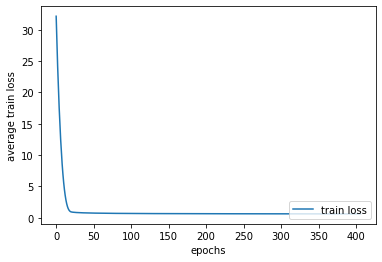

In [35]:
# plot training loss against feed samples 

import pylab

pylab.plot(np.arange(len(entropy_loss)), entropy_loss, label='train loss')
    
pylab.xlabel('epochs')
pylab.ylabel('average train loss')
pylab.legend(loc='lower right')
pylab.savefig('./figures/trainig loss.png')

pylab.show()